In [1]:
from mmdet.apis import init_detector, inference_detector
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import matplotlib.colors as mcolors

In [2]:
#config = 'mmdet_configs/configs/faster_rcnn/faster_rcnn_r50_fpn_2x_coco.py'
#config = 'mmdet_configs/configs/yolo/yolov3_d53_fp16_mstrain-608_273e_coco.py'
config = 'cracks_detr.py'
#checkpoint = 'faster_rcnn_r50_fpn_2x_coco_bbox_mAP-0.384_20200504_210434-a5d8aa15.pth'
#checkpoint = 'yolov3_d53_fp16_mstrain-608_273e_coco_20210517_213542-4bc34944.pth'
checkpoint = 'epoch_40.pth'
device = 'cuda:0'

In [3]:
model = init_detector(config, checkpoint, device)

load checkpoint from local path: epoch_40.pth


In [4]:
label_names=['Arrachement_pelade', 'Faiencage', 'Nid_de_poule',
                 'Transversale', 'Longitudinale', 'Reparation']

In [5]:
colors_list = [[1,0,0], [0,1,0], [0,0,1], [1,0,1], [0,1,1], [1,1,0]]
cmaps = []
for ic in range(len(label_names)):
    colors = [(colors_list[ic][0], colors_list[ic][1], colors_list[ic][2], c) for c in np.linspace(0,1,100)]
    cmaps.append( mcolors.LinearSegmentedColormap.from_list(f'mycmap{ic}', colors, N=5) )

In [6]:
def parse_yolo_annotation(annotation_txtpath):
    """ Parse a yolo annotation file. """
    annotations = []
    with open(annotation_txtpath, "rt") as f_in:
        for line in f_in.readlines():
            line = line.strip()

            cls, x_center, y_center, width, height = line.split()

            annotations.append(
                {
                    "class_index": int(cls),
                    "x_center": float(x_center),
                    "y_center": float(y_center),
                    "width": float(width),
                    "height": float(height),
                }
            )
    return annotations


def yolo_annotations_to_box(yolo_annotations, image, label_names):
    """ Convert a yolo annotation list to (x1, y1, x2, y2) coordinates."""
    image_width = image.shape[1]
    image_height = image.shape[0]
    box_annotations = [[] for _ in range(len(label_names))]

    for annotation in yolo_annotations:
        x1 = int(round((annotation["x_center"]-annotation['width']) * image_width))
        if x1 < 0:
            x1 = 0
        y1 = int(round((annotation["y_center"]-annotation['height']) * image_height))
        if y1 < 0:
            y1 = 0
        x2 = int(round((annotation["x_center"]+annotation['width']) * image_width))
        y2 = int(round((annotation["y_center"]+annotation['height']) * image_height))
        box_annotations[annotation['class_index']].append([x1,y1,x2,y2])

    for c in range(len(label_names)):
        if len(box_annotations[c]) > 0:
            box_annotations[c] = np.stack(box_annotations[c])

    return box_annotations

In [7]:
def generate_mask(image_size, grid_size, prob_thresh):
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
            prob_thresh).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    return mask

In [8]:
def mask_image(image, mask):
    masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) *
              255).astype(np.uint8)
    return masked

In [9]:
def iou(boxes, box):
    box = np.asarray(box)
    tl = np.maximum(boxes[:,:2], box[:2])
    br = np.minimum(boxes[:,2:], box[2:])
    intersection = np.prod(br - tl, axis=1) * np.all(tl < br, axis=1).astype(float)
    area1 = np.prod(boxes[:,2:] - boxes[:,:2], axis=1)
    area2 = np.prod(box[2:] - box[:2])
    return intersection / (area1 + area2 - intersection)

In [10]:
def generate_saliency_map(image,
                          n_classes,
                          target_boxes,
                          prob_thresh=0.5,
                          grid_size=(16, 16),
                          n_masks=5000,
                          seed=0):
    np.random.seed(seed)
    image_h, image_w = image.shape[:2]
    res = [np.zeros((image_h, image_w), dtype=np.float32) for _ in range(n_classes)]
    for i in tqdm.notebook.tqdm(range(n_masks)):
        mask = generate_mask(image_size=(image_w, image_h),
                             grid_size=grid_size,
                             prob_thresh=prob_thresh)
        masked = mask_image(image, mask)
        out = inference_detector(model, masked)
        for ic in range(n_classes):
            boxes = target_boxes[ic]
            pred = out[ic]
            if len(pred) > 0 and len(boxes) > 0:
                score = np.stack([iou(boxes, box) * score for *box, score in pred]).max(axis=0)
                res[ic] += mask * score.sum()
    return res

In [53]:
res = [ [np.zeros((20,30), dtype=np.float32) for _ in range(6)] for _ in range(3)]
len(res[0])

6

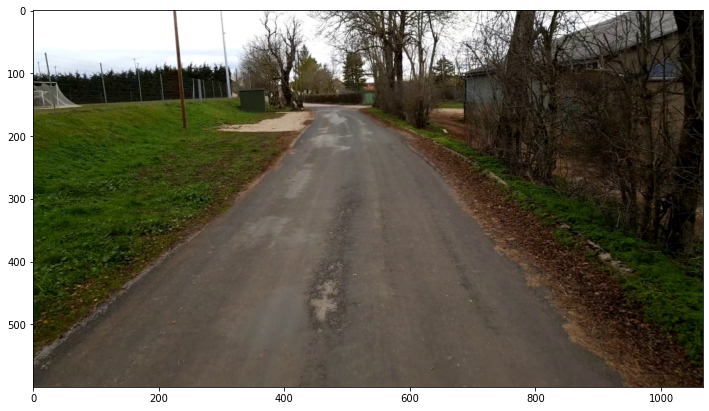

In [56]:
image = cv2.imread('images/000000_32171750-0b62-4e99-90dc-40bbd3b68859_4757.jpg')
scale = 600 / min(image.shape[:2])
image = cv2.resize(image,
                   None,
                   fx=scale,
                   fy=scale,
                   interpolation=cv2.INTER_AREA)
plt.figure(figsize=(12, 12))
plt.imshow(image[:, :, ::-1])
plt.show()

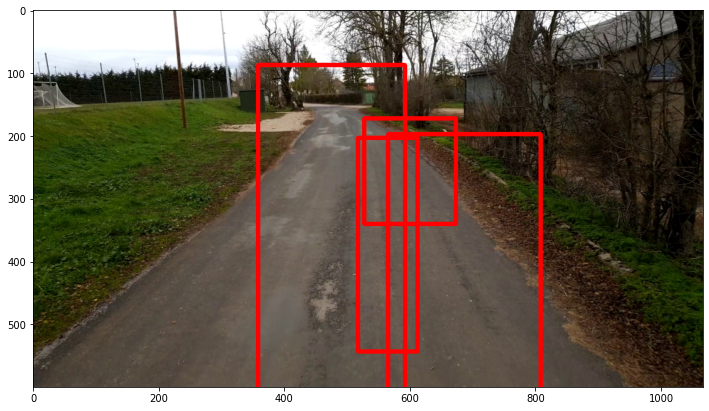

In [57]:
yolo_ann = parse_yolo_annotation('images/000000_32171750-0b62-4e99-90dc-40bbd3b68859_4757.txt')
target_boxes = yolo_annotations_to_box(yolo_ann, image, label_names)

res = image.copy()
for ic in range(len(label_names)):
    for i in range(len(target_boxes[ic])):
            cv2.rectangle(res, target_boxes[ic][i,:2], target_boxes[ic][i, 2:],
                          (np.flip(np.array(colors_list[ic])*255)).tolist(), 5)
plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

/home/theo/workdir/mmdet/mmdetection/mmdet/models/utils/positional_encoding.py:81: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature**(2 * (dim_t // 2) / self.num_feats)
/home/theo/workdir/mmdet/mmdetection/mmdet/models/utils/transformer.py:883: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = temperature**(2

0 Arrachement_pelade (422, 286, 529, 520) 0.50613326
0 Arrachement_pelade (428, 390, 508, 518) 0.30421463


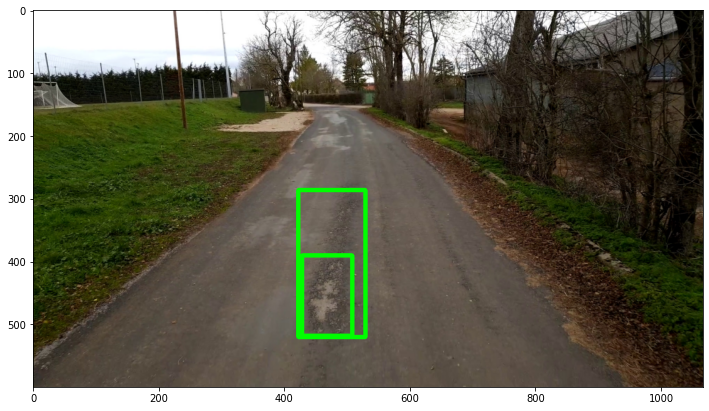

In [31]:
out = inference_detector(model, image)
res = image.copy()
target_boxes = [[] for _ in range(len(label_names))]
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.25:
            break
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        target_boxes[i].append(box)
        cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 5)
    if len(target_boxes[i]) > 0:
        target_boxes[i] = np.stack(target_boxes[i])

plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

In [13]:
saliency_map = generate_saliency_map(image,
                                     n_classes=len(label_names),
                                     target_boxes=target_boxes,
                                     prob_thresh=0.5,
                                     grid_size=(16, 16),
                                     n_masks=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/theo/workdir/mmdet/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/home/theo/workdir/mmdet/mmdetection/mmdet/models/utils/positional_encoding.py:81: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature**(2 * (dim_t // 2) / self.num_feats)
/home/theo/anaconda3/envs/openmmlab/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the i

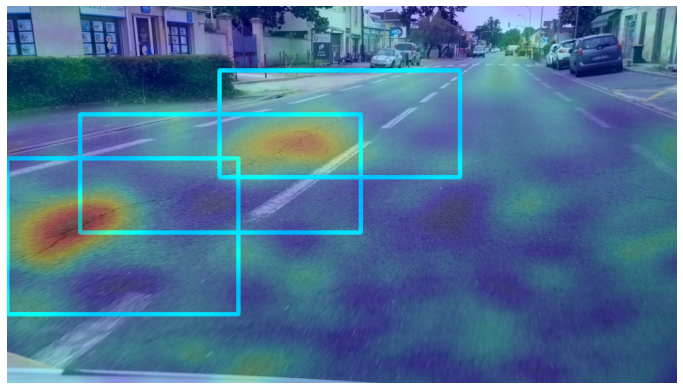

In [14]:
class_id = 4
target_box = target_boxes[class_id]
image_with_bbox = image.copy()
for i in range(len(target_box)):
    cv2.rectangle(image_with_bbox, tuple(target_box[i, :2]),
                  tuple(target_box[i, 2:]), (np.flip(np.array(colors_list[class_id])*255)).tolist(), 5)
        
plt.figure(figsize=(12, 12))
plt.imshow(image_with_bbox[:, :, ::-1])

plt.imshow(saliency_map[class_id], cmap='jet', alpha=0.3)
    
plt.axis('off')
plt.show()

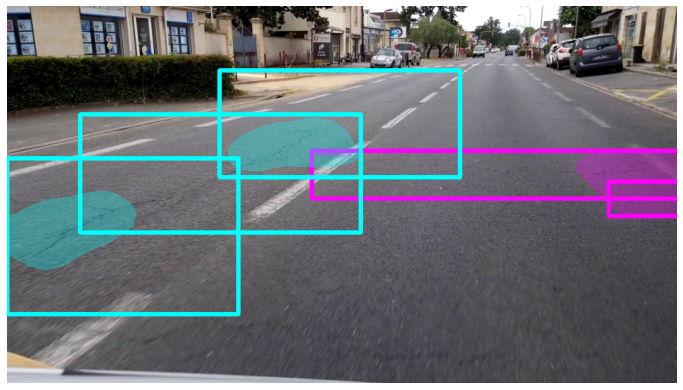

In [20]:
image_with_bbox = image.copy()
for ic in range(len(label_names)):
    for i in range(len(target_boxes[ic])):
        cv2.rectangle(image_with_bbox, tuple(target_boxes[ic][i,:2]),
                      tuple(target_boxes[ic][i,2:]), (np.flip(np.array(colors_list[ic])*255)).tolist(), 5)
        
plt.figure(figsize=(12, 12))
plt.imshow(image_with_bbox[:, :, ::-1])

for ic in range(len(label_names)):
    if saliency_map[ic].sum() > 0:
        box_mask = np.full(saliency_map[ic].shape, False)
        for x1,y1,x2,y2 in target_boxes[ic]:
            box_mask[y1:y2+1, x1:x2+1] = True
        score_mask = saliency_map[ic]>np.percentile(saliency_map[ic], 95)
        segmentation_mask = score_mask & box_mask

        plt.imshow(segmentation_mask, cmap=cmaps[ic], alpha=0.3)
    
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


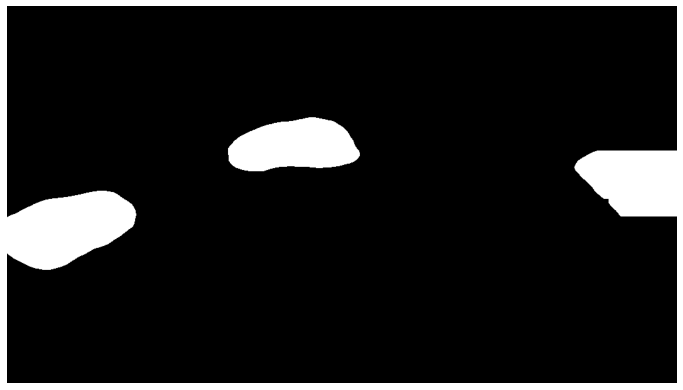

In [46]:
seg_map = np.zeros((image.shape[0], image.shape[1]))
plt.figure(figsize=(12, 12))

for ic in range(len(label_names)):
    if saliency_map[ic].sum() > 0:
        box_mask = np.full(saliency_map[ic].shape, False)
        for x1,y1,x2,y2 in target_boxes[ic]:
            box_mask[y1:y2+1, x1:x2+1] = True
        score_mask = saliency_map[ic]>np.percentile(saliency_map[ic], 95)
        segmentation_mask = score_mask & box_mask

        seg_map = np.where(segmentation_mask, ic, seg_map)

seg_map = np.transpose(np.stack([seg_map,seg_map,seg_map]), (1,2,0))
plt.imshow(seg_map)
plt.axis('off')
plt.show()

In [43]:
image_with_bbox.shape

(600, 1067, 3)

In [45]:
np.unique(seg_map)

array([ 0., 30., 40.])